<a href="https://colab.research.google.com/github/JieQinHHU/colab/blob/main/LSTMandGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-7aeae6b4c708>:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_train = torch.tensor([seq for seq, _ in train_data], dtype=torch.float32)


Epoch [1/50], Train Loss: 0.0247, Valid Loss: 0.0020
Epoch [2/50], Train Loss: 0.0022, Valid Loss: 0.0011
Epoch [3/50], Train Loss: 0.0014, Valid Loss: 0.0008
Epoch [4/50], Train Loss: 0.0008, Valid Loss: 0.0004
Epoch [5/50], Train Loss: 0.0006, Valid Loss: 0.0003
Epoch [6/50], Train Loss: 0.0005, Valid Loss: 0.0003
Epoch [7/50], Train Loss: 0.0004, Valid Loss: 0.0002
Epoch [8/50], Train Loss: 0.0004, Valid Loss: 0.0002
Epoch [9/50], Train Loss: 0.0003, Valid Loss: 0.0002
Epoch [10/50], Train Loss: 0.0003, Valid Loss: 0.0002
Epoch [11/50], Train Loss: 0.0002, Valid Loss: 0.0001
Epoch [12/50], Train Loss: 0.0002, Valid Loss: 0.0001
Epoch [13/50], Train Loss: 0.0002, Valid Loss: 0.0001
Epoch [14/50], Train Loss: 0.0002, Valid Loss: 0.0001
Epoch [15/50], Train Loss: 0.0002, Valid Loss: 0.0001
Epoch [16/50], Train Loss: 0.0002, Valid Loss: 0.0001
Epoch [17/50], Train Loss: 0.0001, Valid Loss: 0.0001
Epoch [18/50], Train Loss: 0.0001, Valid Loss: 0.0001
Epoch [19/50], Train Loss: 0.0001, Va

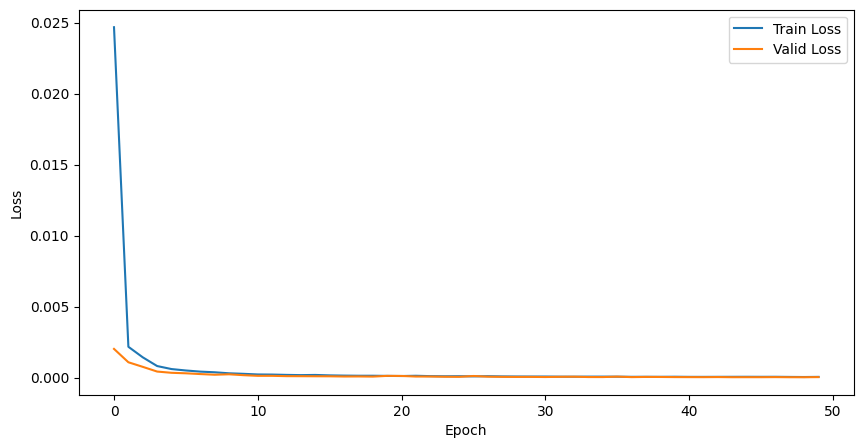

Test RMSE: 468.1490


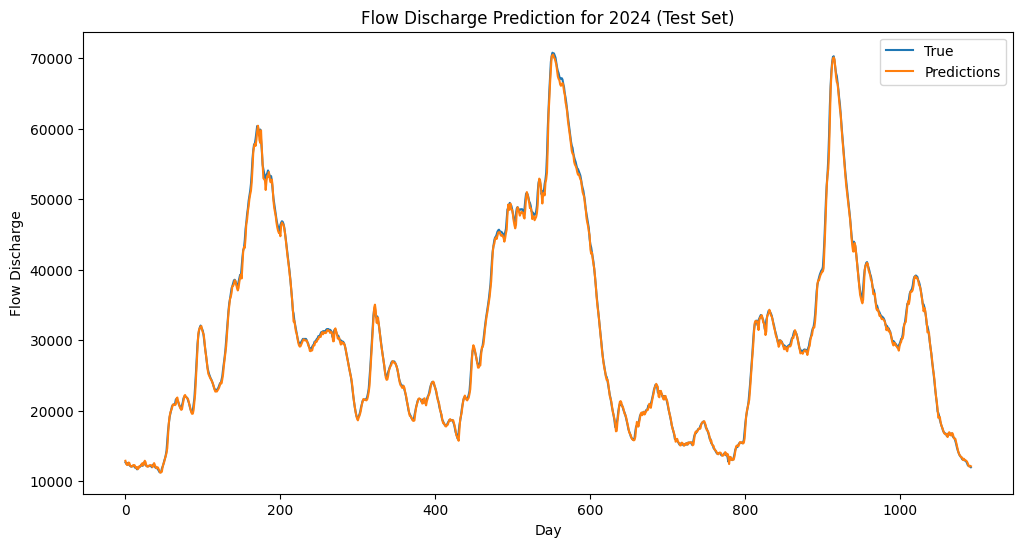

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# 加载数据
# Load your dataset (replace 'your_dataset.csv' with your actual dataset)
dataset = pd.read_csv('WutengData.csv')

# 提取数据
# Extract the daily flow discharge data (replace 'Flow_Discharge' with your column name)
data = dataset['Q'].values.astype(float)

# 标准化数据
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1))

# 创建sequence
# Define a function to create sequences of data
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append((seq, target))
    return sequences

# 定义sequence长度，定义训练集，验证集，测试集
# Set the sequence length and split the data into train, validation, and test sets
# how many past time steps your model considers when making predictions.
# Longer sequence lengths capture more context. batch size is about how you group
# and process those sequences during training. Epochs control how many times your
# model sees and learns from the entire training dataset.
sequence_length = 30  # You can adjust this as needed
sequences = create_sequences(data, sequence_length)
train_size = int(0.7 * len(sequences))
valid_size = int(0.15 * len(sequences))
test_size = len(sequences) - train_size - valid_size

train_data = sequences[:train_size]
valid_data = sequences[train_size:train_size + valid_size]
test_data = sequences[train_size + valid_size:]


# Split the data into features (X) and target (y)
X_train = torch.tensor([seq for seq, _ in train_data], dtype=torch.float32)
y_train = torch.tensor([target for _, target in train_data], dtype=torch.float32)
X_valid = torch.tensor([seq for seq, _ in valid_data], dtype=torch.float32)
y_valid = torch.tensor([target for _, target in valid_data], dtype=torch.float32)
X_test = torch.tensor([seq for seq, _ in test_data], dtype=torch.float32)
y_test = torch.tensor([target for _, target in test_data], dtype=torch.float32)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model
input_size = 1  # Input size is 1 for daily flow discharge
hidden_size = 50
num_layers = 2
output_size = 1  # Output size is also 1
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
batch_size = 64

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()
    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test the model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)
    test_predictions = scaler.inverse_transform(test_predictions.numpy())
    y_test = scaler.inverse_transform(y_test.numpy())

# Calculate RMSE for the test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f'Test RMSE: {test_rmse:.4f}')

# Plot the predictions vs. actual values for the test set
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True')
plt.plot(test_predictions, label='Predictions')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Flow Discharge')
plt.title('Flow Discharge Prediction for 2024 (Test Set)')
plt.show()
